### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. 
Для этого мы применяем метод A/B–тестирования. 
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте,
у контрольной группы оставалась базовая механика. 
В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод,
стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или
экспериментальной группе (А – контроль, B – целевая группа) <br> 
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных <br> 
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. <br> 
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.<br> 
<br>
### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?<br> 
Имеются ли различия в показателях и с чем они могут быть связаны?<br> 
Являются ли эти различия статистически значимыми?<br> 
Стоит ли запускать новую механику на всех пользователей?<br> 
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

### 1.4 Требования к ответу

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import ttest_ind
import statsmodels.stats.proportion as proportion
import statsmodels.stats.power as smp

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

import requests
from urllib.parse import urlencode

In [2]:
def loaded_data(base_url='https://cloud-api.yandex.net/v1/disk/public/resources/download?',
                    groups='https://disk.yandex.ru/d/UhyYx41rTt3clQ',
                    groups_add='https://disk.yandex.ru/d/5Kxrz02m3IBUwQ',
                    active_studs='https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ',
                    checks='https://disk.yandex.ru/d/pH1q-VqcxXjsVA'):
    
    # загрузим данные с диска
    url_groups= base_url + urlencode(dict(public_key= groups)) 
    url_groups_add= base_url + urlencode(dict(public_key= groups_add))
    url_key_active_studs = base_url + urlencode(dict(public_key= active_studs))
    url_key_checks= base_url + urlencode(dict(public_key= checks))

    df_groups= pd.read_csv(requests.get(url_groups).json()['href'], sep= ';')
    df_groups_add= pd.read_csv(requests.get(url_groups_add).json()['href'], sep= ',')
    df_active_studs = pd.read_csv(requests.get(url_key_active_studs).json()['href'], sep= ';')
    df_checks = pd.read_csv(requests.get(url_key_checks).json()['href'], sep= ';')
    
    # подготовка данных
    df_groups = pd.concat([df_groups, df_groups_add], axis=0)
    df_groups = df_groups.rename(columns={'id':'student_id'})
    df_active_studs['active'] = 1
    df = (df_groups
            .merge(df_active_studs,
                   how='left',
                   left_on='student_id',
                   right_on='student_id')
            .merge(df_checks,
                   how='left',
                   on='student_id')
          )
    df['active'] = df['active'].fillna(0).astype(int)
    df['rev'] = df['rev'].fillna(0).astype(int)
    
    return df

In [3]:
full_df = loaded_data()
full_df

,student_id,grp,active,rev
0,1489,B,0,0
1,1627,A,1,990
2,1768,B,0,0
3,1783,B,0,0
4,1794,A,0,0
...,...,...,...,...
74571,200247820,B,0,0
74572,201032527,B,0,0
74573,201067612,B,0,0
74574,201067653,B,0,0


**student_id** - id студента<br>
**grp** - группа (а - контрольная, б - тестовая)<br>
**active** - пользователи, которые зашли на платформу в дни проведения эксперимента<br>
**rev** - оплата<br>






In [4]:
# Посмотрим , что есть в наших данных. размер групп,
# разделенную по группам и активности,
# кол-во уникальных пользователей и сравним с общим числом пользователей
print(
    full_df['grp'].value_counts(), 
    full_df['grp'].value_counts(normalize=True),
    full_df.groupby(['grp','active'])['rev'].sum(),
    full_df.groupby('grp')['student_id'].agg(['count','nunique'])
    )

B    59883
A    14693
Name: grp, dtype: int64 B    0.80298
A    0.19702
Name: grp, dtype: float64 grp  active
A    0          19276
     1          72820
B    0          86256
     1         394974
Name: rev, dtype: int64      count  nunique
grp                
A    14693    14693
B    59883    59883


In [5]:
# Посмтрим распределение студентов по группам
def plot_segment_distribution(df, segment_columns, test_factor):
    for segment in segment_columns:
        agg_data = df.groupby(by = [test_factor, segment])\
        .rev.sum().reset_index()
        sns.catplot(x = segment, y= 'rev',hue = test_factor,
                   data = agg_data, kind = 'bar',
                   height = 4, aspect = 1.5)

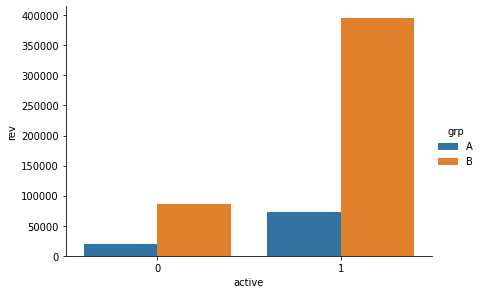

In [6]:
plot_segment_distribution(full_df,['active'],'grp')

***В наших данных есть часть данных с пользователями , которые не были активны в дни проведения тестов. В том числе оплатившие курс. Однако , нельзя достоверно утверждать откуда они появились. Следовательно их необходимо отделить от исследуемых данных.***

In [7]:
print(full_df\
    .query('active ==0')\
    .groupby(['grp'])[['student_id','rev']]\
    .agg({'student_id':'count', 'rev':'sum'}), 
    full_df\
    .query("active == 0 and rev > 0")\
    .groupby(['grp'])[['student_id','rev']]\
    .agg({'student_id':'count', 'rev':'sum'}) 
     )

     student_id    rev
grp                   
A         13155  19276
B         53080  86256      student_id    rev
grp                   
A            29  19276
B           120  86256


В итоге получается, что у нас 149 человек оплатили услугу, но при этом не проявляли активность во время проведения теста. 
Нельзя точно сказать в чем причина. ошибка при переводе или отложенный платеж. Но эти данные стоит исключить.

In [8]:
full_df['paid_flag'] = (full_df['rev'] > 0).astype(int)

In [9]:
active_df = full_df.query('active !=0')


# Подготовим сводную таблицу с интересующими нас метриками
# Сгруппируем и посчитаем основные показатели по группам
active_grp_df = (active_df
         .groupby(['grp']
                  , as_index = False)
         .agg({'student_id':'count' , 'rev':'sum'})\
         .rename(columns={'student_id' : 'count_student' , 'rev' : 'rev_sum' })
                )
# Отдельно расчитаем количество заплтивших студентов
count_a = (active_df
           .query('rev > 0 & grp == "A"')['student_id']
           .count()
          )
count_b = (active_df
           .query('rev > 0 & grp == "B"')['student_id']
           .count())
# Добавим оплативших к нашей таблице
active_grp_df['payed_studs'] = 0  
active_grp_df.loc[active_grp_df['grp'] == 'A', 'payed_studs'] = count_a
active_grp_df.loc[active_grp_df['grp'] == 'B', 'payed_studs'] = count_b
# Посчитаем ARPU - отношение общей суммы платежей к количеству активных пользователей.
active_grp_df['arpu'] = ((active_grp_df\
                          .rev_sum/active_grp_df\
                          .count_student)
                          .round(2)
                        )
# Посчитаем ARPPU - отношение общей суммы к количеству активных оплативших пользователей.
active_grp_df['arppu'] = ((active_grp_df\
                           .rev_sum/active_grp_df\
                           .payed_studs)
                           .round(2)
                         )
# Посчитаем CR - отношение оплатиших пользователей к общему числу студентов в процентах.
active_grp_df['cr'] = (((active_grp_df\
                         .payed_studs/active_grp_df\
                         .count_student)
                         *100)
                         .round(2)
                      )
active_grp_df

,grp,count_student,rev_sum,payed_studs,arpu,arppu,cr
0,A,1538,72820,78,47.35,933.59,5.07
1,B,6803,394974,314,58.06,1257.88,4.62


Мы видим увеличение ARPPU и ARPU , но незначительное падение CR. Следовательно у нас увеличивается платеж от одного пользователя. Но по всей видимости при этом мы теряем часть менее платежеспособных клиентов.

## Статзначимость
 Стоит отметить, что группы по размерам сильно отличаются, то в данном случае лучше использовать метод Bootstrap.

### Сформулируем гипотезу ARPU(отношение общей суммы платежей к количеству активных пользователей)
H0 - новая механника не привела к изменнениям метрик
Н1 - новая мехуника привела к изменения

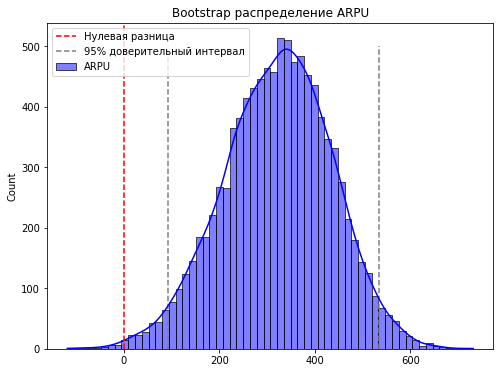

In [10]:
# Разделение данных на две группы A и B
ctrl_A = active_df[(active_df['grp'] == 'A') & (active_df['rev'] > 0)]
test_B = active_df[(active_df['grp'] == 'B') & (active_df['rev'] > 0)]
rev_A = ctrl_A['rev'].values
rev_B = test_B['rev'].values

# Bootstrap анализ для ARPU
boot_result_arpu = bs.bootstrap_ab(test=rev_B, ctrl=rev_A, stat_func=bs_stats.mean, compare_func=bs_compare.difference, return_distribution=True)

borders = np.percentile(boot_result_arpu, [2.5, 97.5])

# Визуализация результатов
plt.figure(figsize=(8, 6))
sns.histplot(boot_result_arpu, kde=True, color='blue', label='ARPU')
plt.title('Bootstrap распределение ARPU')
plt.axvline(0, color='red', linestyle='--', label='Нулевая разница')
plt.vlines(borders, ymin=0, ymax=500, linestyles='--', colors='grey', label='95% доверительный интервал')
plt.legend()
plt.show()

### "0" не попадает в довериельный интервал - отметаем H0 гипотезу!
Различие считается статистически значимым.

### Сформулируем гипотезу ARPPU(отношение общей суммы платежей к количеству активных пользователей)
H0 - новая механника не привела к изменнениям метрик Н1 - новая мехуника привела к изменения

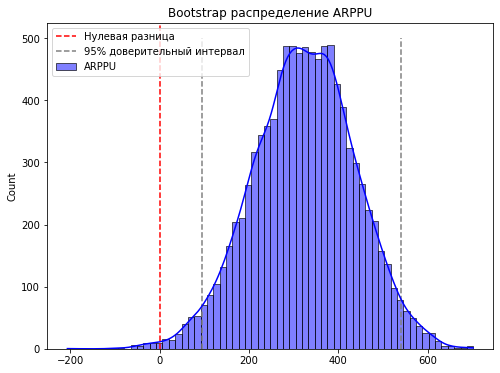

In [12]:
# Извлечение данных о выручке только от платящих пользователей для каждой группы
rev_A_pay = ctrl_A[ctrl_A['paid_flag'] == 1]['rev'].values
rev_B_pay = test_B[test_B['paid_flag'] == 1]['rev'].values

# Bootstrap анализ для ARPPU
boot_result_arppu = bs.bootstrap_ab(test=rev_B_pay,
                                    ctrl=rev_A_pay, 
                                    stat_func=bs_stats.mean, 
                                    compare_func=bs_compare.difference,
                                    return_distribution=True
                                   )

borders = np.percentile(boot_result_arppu, [2.5, 97.5])

# Визуализация результатов
plt.figure(figsize=(8, 6))
sns.histplot(boot_result_arppu, kde=True, color='blue', label='ARPPU')
plt.title('Bootstrap распределение ARPPU')
plt.axvline(0, color='red', linestyle='--', label='Нулевая разница')
plt.vlines(borders, ymin=0, ymax=500, linestyles='--', colors='grey', label='95% доверительный интервал')
plt.legend()
plt.show()

### "0" не попадает в довериельный интервал - отметаем H0 гипотезу!
Различие считается статистически значимым.

### Сформулируем гипотезу СR(оказатель конверсии из активного в оплатившего)
H0 - новая механника не привела к изменнениям метрик Н1 - новая мехуника привела к изменения

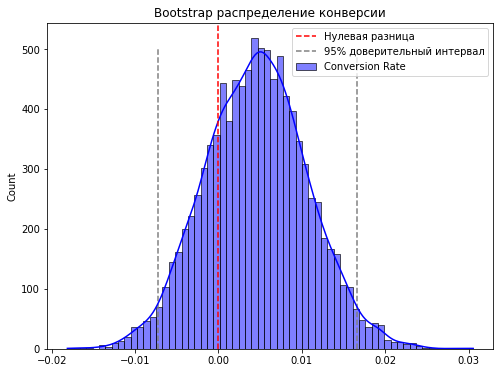

In [13]:
# Расчет конверсии для каждой группы
conversion_A = active_df[active_df['grp'] == 'A']['paid_flag'].values
conversion_B = active_df[active_df['grp'] == 'B']['paid_flag'].values

# Bootstrap анализ для конверсии
boot_result_conversion = bs.bootstrap_ab(test=conversion_A,
                                         ctrl=conversion_B,
                                         stat_func=bs_stats.mean, 
                                         compare_func=bs_compare.difference, 
                                         return_distribution=True)

# Расчет доверительных интервалов
borders = np.percentile(boot_result_conversion, [2.5, 97.5])

# Визуализация результатов
plt.figure(figsize=(8, 6))
sns.histplot(boot_result_conversion, kde=True, color='blue', label='Conversion Rate')
plt.title('Bootstrap распределение конверсии')
plt.axvline(0, color='red', linestyle='--', label='Нулевая разница')
plt.vlines(borders, ymin=0, ymax=500, linestyles='--', colors='grey', label='95% доверительный интервал')
plt.legend()
plt.show()


## "0" попадает в довериельный интервал - принимаем H0 гипотезу!
Различие считается статистически значимым.

## ВЫВОД

Входе проведенных исследований было установлена вероятная статистически значимая взаимосвязь в ростом таких метрик ,как ARPU и ARPPU и небольшое снижение конверсии CR не являющееся статистически значимы. Из чего можно сделать вывод , что стоит применить эту механнику на всю аудиторию.

## Задание 2. SQL
### 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

### 2.1.2 Задача

Дана таблица default.peas:

Название атрибута |Тип атрибута	| Смысловое значение<br>
st_id | int	ID | ученика<br>
timest | timestamp | Время решения карточки<br>
correct | bool | Правильно ли решена горошина?<br>
subject | text | Дисциплина, в которой находится горошина


Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [14]:
# Импортируем библиотеку
import pandahouse as ph

In [15]:
# Далее создаем словарь connection с нужными параметрами для подключения к default
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [16]:
# создаем запрос ,где отбираем уникальных студентов и меняем им на very_diligent_students
#  из таблицы peas. 
#  Добавляем фильтр только правильных ответов и месяц "текущий"
#  группируем и отбираем только тех кто завершил не менее 20 горошин
#  и оборачиваем все это в подзапрос
v_d_s =""" 
    SELECT
        COUNT(*) AS very_diligent_students
    FROM (
        SELECT
            st_id
        FROM
            {db}.peas
        WHERE
            correct = 1 AND toMonth(timest) = toMonth(now()) 
        GROUP BY 
            st_id 
        HAVING 
            COUNT(correct) >= 20
    ) subquery
"""   

# отправляем запрос и записываем результат 
v_d_s_df = ph.read_clickhouse(query=v_d_s, connection=connection_default)
v_d_s_df

,very_diligent_students
0,0


Запрос выдает пустой результат так как максиальная дата в дата фейме ограничена 2021 годом.

### 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача

Дана таблицы: default.peas (см. выше), default.studs:

Название атрибута	Тип атрибута	Смысловое значение
st_id	int	 ID ученика
test_grp	text	 Метка ученика в данном эксперименте
и default.final_project_check:

Название атрибута	Тип атрибута	Смысловое значение
st_id	int 	ID ученика
sale_time	timestamp	Время покупки
money	int	Цена, по которой приобрели данный курс
subject	text 	
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:<br>

ARPU<br> 
ARPAU <br>
CR в покупку<br>
СR активного пользователя в покупку<br> 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике<br>
ARPU считается относительно всех пользователей, попавших в группы.<br>

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [27]:
# воспользуемся модулем WITH для подготовки данных, найдем активных студнетов, найдем активных математиков,
# посчитаем ARPU, ARPAU, CR в покупку, СR активного пользователя в покупку,
# CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
# разделив пользователей по группам.
metrics =""" 
   WITH 
    activ_student AS (
        SELECT st_id, COUNT(correct) AS correct_count
        FROM default.peas
        GROUP BY st_id 
        HAVING correct_count > 10
    ), 
    active_math AS (
        SELECT st_id, SUM(correct) AS corr_count 
        FROM default.peas 
        WHERE subject = 'Math' 
        GROUP BY st_id 
        HAVING corr_count >= 2
    ), 
    arpu AS (
        SELECT test_grp, ROUND(SUM(money) / COUNT(studs.st_id), 2) AS ARPU 
        FROM default.studs AS students 
        LEFT JOIN default.final_project_check AS f_p_c ON students.st_id = f_p_c.st_id 
        GROUP BY test_grp
    ), 
    arpau AS (
        SELECT test_grp, ROUND(SUM(money) / COUNT(students.st_id), 2) AS ARPAU 
        FROM default.studs AS students 
        LEFT JOIN default.final_project_check AS f_p_c ON students.st_id = f_p_c.st_id 
        WHERE st_id IN (SELECT st_id FROM activ_student) 
        GROUP BY test_grp
    ),
    cr AS (
        SELECT test_grp, ROUND(COUNTIf(money > 0) / COUNT(students.st_id), 2) AS CR 
        FROM default.studs AS students 
        LEFT JOIN default.final_project_check AS f_p_c ON students.st_id = f_p_c.st_id 
        GROUP BY test_grp
    ),
    cr_active AS (
        SELECT test_grp, ROUND(COUNTIf(money > 0) / COUNT(students.st_id), 2) AS CR_ACTIVE
        FROM default.studs AS students 
        LEFT JOIN default.final_project_check AS f_p_c ON students.st_id = f_p_c.st_id 
        WHERE st_id IN (SELECT st_id FROM activ_student) 
        GROUP BY test_grp
    ), 
    cr_math AS (
        SELECT test_grp, 
        ROUND(COUNTIf(money > 0 AND subject = 'Math') / COUNT(students.st_id), 2) AS CR_MATH
        FROM default.studs AS students 
        LEFT JOIN default.final_project_check AS f_p_c ON students.st_id = f_p_c.st_id 
        WHERE st_id IN (SELECT st_id FROM active_math) 
        GROUP BY test_grp
    ) 
SELECT arpu.test_grp AS GROUP, ARPU, ARPAU, CR, CR_ACTIVE, CR_MATH 
FROM 
    arpu 
    INNER JOIN arpau ON arpu.test_grp = arpau.test_grp 
    INNER JOIN cr ON arpu.test_grp = cr.test_grp 
    INNER JOIN cr_active ON arpu.test_grp = cr_active.test_grp 
    INNER JOIN cr_math ON arpu.test_grp = cr_math.test_grp

"""   

# отправляем запрос и записываем результат 
metrics_df = ph.read_clickhouse(query=metrics, connection=connection_default)
metrics_df


,GROUP,ARPU,ARPAU,CR,CR_ACTIVE,CR_MATH
0,control,4496.75,8993.51,0.06,0.12,0.06
1,pilot,11094.77,22290.08,0.14,0.27,0.09


### Задание 3. Python
### 3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [47]:
def loaded_data(base_url='https://cloud-api.yandex.net/v1/disk/public/resources/download?',
                    groups='https://disk.yandex.ru/d/UhyYx41rTt3clQ',
                    groups_add='https://disk.yandex.ru/d/5Kxrz02m3IBUwQ',
                    active_studs='https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ',
                    checks='https://disk.yandex.ru/d/pH1q-VqcxXjsVA'):
    
    # загрузим данные с диска
    url_groups= base_url + urlencode(dict(public_key= groups)) 
    url_groups_add= base_url + urlencode(dict(public_key= groups_add))
    url_key_active_studs = base_url + urlencode(dict(public_key= active_studs))
    url_key_checks= base_url + urlencode(dict(public_key= checks))

    df_groups = pd.read_csv(requests\
                           .get(url_groups)\
                           .json()['href'], sep= ';'
                           )
    df_groups_add = pd.read_csv(requests\
                               .get(url_groups_add)\
                               .json()['href'], sep= ','
                               )
    df_active_studs = pd.read_csv(requests\
                                  .get(url_key_active_studs)\
                                  .json()['href'], sep= ';'
                                 )
    df_checks = pd.read_csv(requests\
                           .get(url_key_checks)\
                           .json()['href'], sep= ';'
                           )
    
    #подготовка данных
    df_groups = pd.concat([df_groups, df_groups_add], axis=0)
    df_groups = df_groups.rename(columns={'id': 'student_id'})
    df_active_studs['active'] = 1
    df = (df_groups
            .merge(df_active_studs,
                   how='left',
                   left_on='student_id',
                   right_on='student_id')\
            .merge(df_checks,
                   how='left',
                   on='student_id')
          )
    df['active'] = df['active'].fillna(0).astype(int)
    df.loc[df['active'] != 0, 'active'] = 0
    df['rev'] = df['rev'].fillna(0).astype(int)
    # отсортируем студентов по группам с фильтрацией А/Б и активный/неактивный
    student_count_df = (df
                        .groupby(['grp', 'active'])['student_id']
                        .count()
                        .reset_index()
                        .rename(columns={'student_id': 'student_count'})
                       )
    # посчитаем сколькиие из них совершили покупку
    student_rev_count = (df
                         .query('rev > 0')
                         .groupby(['grp', 'active'])['student_id']
                         .count()
                         .reset_index()
                         .rename(columns={'student_id': 'student_rev_count'})
                        )
    # сумму выручки по группам
    rev_df = (df
              .groupby(['grp', 'active'], as_index=False)['rev'].sum().round(2)
             )
    # соберем в одну таблицу
    metric = (student_count_df
              .merge(rev_df,
                     on=['grp', 'active'],
                     how='inner')
              .merge(student_rev_count,
                     on=['grp', 'active'],
                     how='inner')
              )


    # ARPU 
    metric['arppu'] = (metric['rev'] / metric['student_rev_count']).round(2)
    # ARPPU 
    metric['arpu'] = (metric['rev'] / metric['student_count']).round(2)
    
    # и конверсию 
    metric['cr'] = ((metric['student_rev_count'] / metric['student_count']) * 100).round(2)
   
       
    return metric
 

In [48]:
result_table = loaded_data()


In [49]:
result_table

,grp,active,student_count,rev,student_rev_count,arppu,arpu,cr
0,A,0,14693,92096,107,860.71,6.27,0.73
1,B,0,59883,481230,434,1108.82,8.04,0.72


In [38]:
def plots(result_table):
    """
    Функция для создания и отображения графиков метрик из таблицы результатов.
    
    Args:
        result_table (DataFrame): Таблица с результатами метрик.
    """
    
    # Создание subplot'ов
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 10), sharey='col', sharex=True)
    
    # Настройка каждого subplot'а
    for name, ax in zip(['Conversion Rate', 'ARPU', 'ARPPU', 'Revenue'], axs.flatten()):
        ax.set(title=f'График {name}')
        ax.tick_params(labelbottom=True, which='both')

    # Построение графиков
    axs[0].bar(result_table.grp, result_table['cr'])
    axs[1].bar(result_table.grp, result_table['arpu'])
    axs[2].bar(result_table.grp, result_table['arppu'])
    axs[3].bar(result_table.grp, result_table['rev'])
    
    # Добавление общего заголовка
    fig.suptitle('Метрики')
    
    # Отображение графиков
    plt.show()


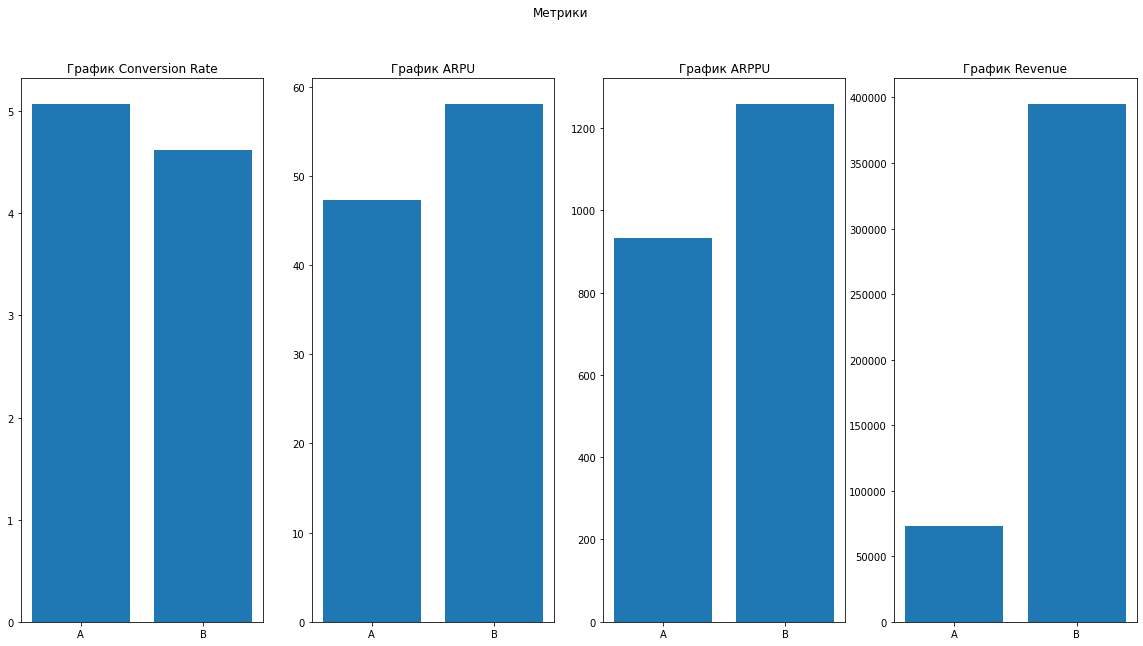

In [39]:
plots(result_table)